### NOTES

- wm_yr_wk: "walmart data, year, week number"

- snap: Supplemental Nutrition Assistance Program (SNAP) (????)


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import timedelta

from process import * 

# date_mapper = {f"d_{i}": d for i, d in enumerate(pd.date_range("2011-01-29", "2016-06-19"))}

### Calendar:

snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [3]:

calendar = load_calendar(PATH_INPUT)
print(calendar.shape)
calendar.tail()

(1969, 10)


date  wm_yr_wk  event_name_1 event_type_1  event_name_2  \
1964 2016-06-15     11620           nan          nan           nan   
1965 2016-06-16     11620           nan          nan           nan   
1966 2016-06-17     11620           nan          nan           nan   
1967 2016-06-18     11621           nan          nan           nan   
1968 2016-06-19     11621  NBAFinalsEnd     Sporting  Father's day   

     event_type_2  snap_CA  snap_TX  snap_WI       d  
1964          nan        0        1        1  d_1965  
1965          nan        0        0        0  d_1966  
1966          nan        0        0        0  d_1967  
1967          nan        0        0        0  d_1968  
1968     Cultural        0        0        0  d_1969

In [4]:
calendar["event_type_1"].unique(), calendar["event_type_2"].unique(), 

(['nan', 'Sporting', 'Cultural', 'National', 'Religious']
 Categories (5, object): ['Cultural', 'National', 'Religious', 'Sporting', 'nan'],
 ['nan', 'Cultural', 'Religious']
 Categories (3, object): ['Cultural', 'Religious', 'nan'])

In [109]:
calendar["event_name_1"].unique()

['nan', 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', ..., 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']
Length: 31
Categories (31, object): ['Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay', ..., 'Thanksgiving', 'ValentinesDay', 'VeteransDay', 'nan']

In [286]:
# NOTE: Base on this I will not use event_type_2: 5 items which are repeated on the type event 1.
calendar[calendar["event_type_2"]!="nan"]

date  wm_yr_wk    event_name_1 event_type_1    event_name_2  \
85   2011-04-24     11113  OrthodoxEaster    Religious          Easter   
827  2013-05-05     11315  OrthodoxEaster    Religious   Cinco De Mayo   
1177 2014-04-20     11412          Easter     Cultural  OrthodoxEaster   
1233 2014-06-15     11420    NBAFinalsEnd     Sporting    Father's day   
1968 2016-06-19     11621    NBAFinalsEnd     Sporting    Father's day   

     event_type_2  snap_CA  snap_TX  snap_WI       d  
85       Cultural        0        0        0    d_86  
827      Cultural        1        1        1   d_828  
1177    Religious        0        0        0  d_1178  
1233     Cultural        0        1        1  d_1234  
1968     Cultural        0        0        0  d_1969

In [291]:
type_1_cols = ["date", "event_name_1", "event_type_1"]
type_2_cols = ["date", "event_name_2", "event_type_2"]
pd.merge(calendar[calendar["event_type_2"]!="nan"][type_1_cols], calendar[calendar["event_type_1"]!="nan"][type_2_cols], on="date")

date    event_name_1 event_type_1    event_name_2 event_type_2
0 2011-04-24  OrthodoxEaster    Religious          Easter     Cultural
1 2013-05-05  OrthodoxEaster    Religious   Cinco De Mayo     Cultural
2 2014-04-20          Easter     Cultural  OrthodoxEaster    Religious
3 2014-06-15    NBAFinalsEnd     Sporting    Father's day     Cultural
4 2016-06-19    NBAFinalsEnd     Sporting    Father's day     Cultural

**NOTE: May be we should agree how to call/represent those special days.**

---

### Prices

In [5]:
prices = load_prices(PATH_INPUT)
print(prices.shape)
print(prices.dtypes)
prices.head()

(6841121, 4)
store_id      category
item_id       category
wm_yr_wk        uint16
sell_price     float32
dtype: object


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [66]:
prices.describe().round(0).T

count     mean    std      min      25%      50%      75%  \
wm_yr_wk    6841121.0  11383.0  149.0  11101.0  11247.0  11411.0  11517.0   
sell_price  6841121.0      4.0    3.0      0.0      2.0      3.0      6.0   

                max  
wm_yr_wk    11621.0  
sell_price    107.0

In [34]:
print("Items:", prices["item_id"].unique()[:1], "\n")
print("Stores:", prices["store_id"].unique(), "\n")

Items: ['HOBBIES_1_001']
Categories (3049, object): ['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', 'HOBBIES_1_004', ..., 'FOODS_3_824', 'FOODS_3_825', 'FOODS_3_826', 'FOODS_3_827'] 

Stores: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3'] 



In [37]:
# cond = prices["item_id"].isin(["HOBBIES_1_010"])
# ds = prices[cond]
# print(set(ds["store_id"].cat.remove_unused_categories().values))

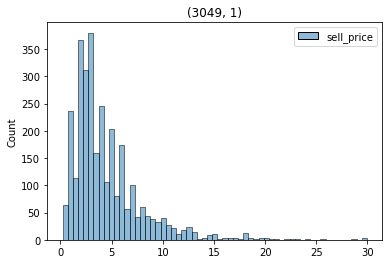

In [38]:
items_prices = prices.groupby("item_id", observed=False)[["sell_price"]].mean()
ax = sns.histplot(items_prices)
_ = ax.set_title(f'{items_prices.shape}')

In [12]:
bins = [0, 5, 10, 15, 30]
labels = ['0-5','6-10', '11-15', '16-30']

# Count values by range directly
range_counts = pd.cut(items_prices['sell_price'], bins=bins, labels=labels, right=True, include_lowest=True).value_counts().sort_index()
range_counts

sell_price
0-5      2153
6-10      693
11-15     146
16-30      57
Name: count, dtype: int64

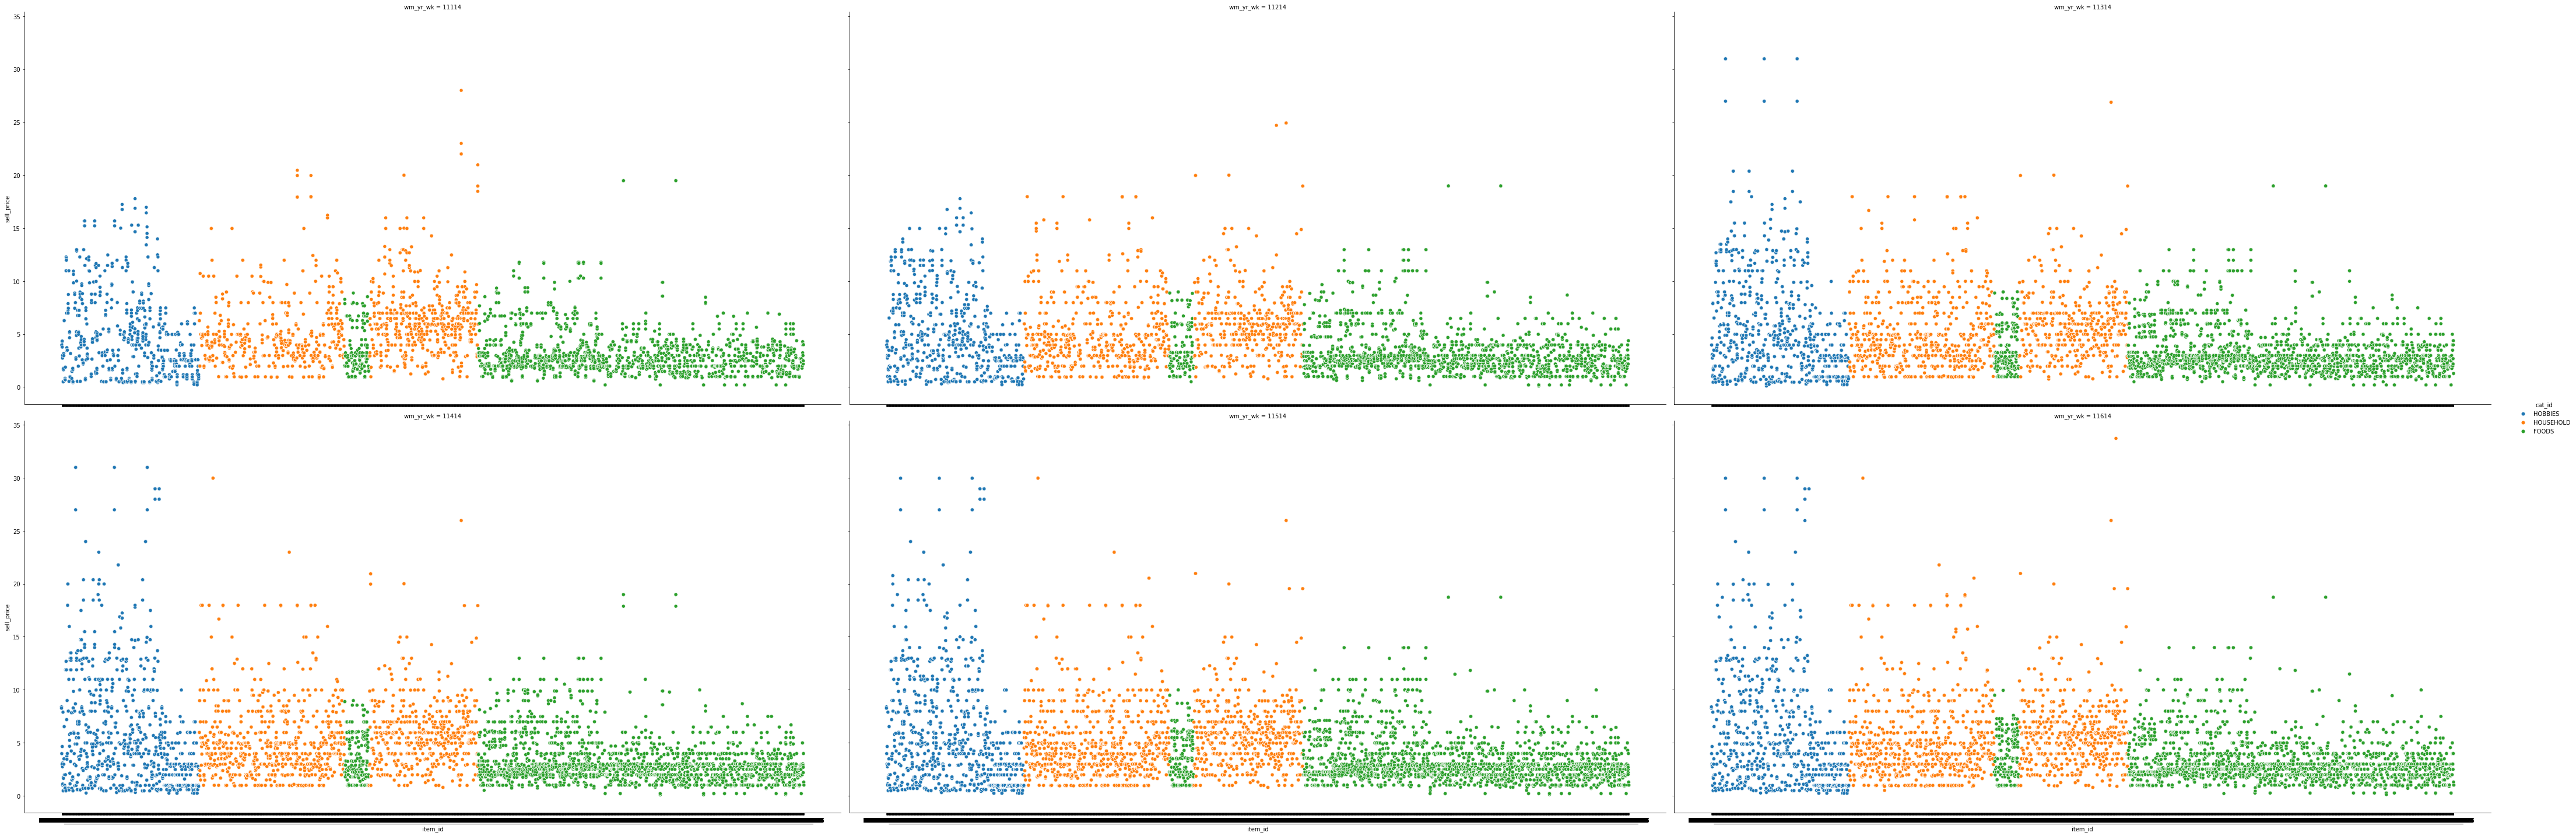

In [74]:
#### Which products are more expensive? and how it evolves with time? 
#### Runs in 2min!!!

# prices["cat_id"] = prices["item_id"].str.split("_").apply(lambda x: x[0])
# cond = prices["wm_yr_wk"].isin([11114, 11214, 11314, 11414, 11514, 11614])
# data=prices[cond].sort_values("item_id")
# sns.relplot(data=data, x="item_id", y="sell_price", hue="cat_id", col="wm_yr_wk", col_wrap=3, aspect=2, height=10)

In [75]:
# s = prices.groupby("item_id", observed=False)[["sell_price"]].describe()
# s["CV"] = s[('sell_price',   'std')]/s[('sell_price',   'mean')]
# sns.histplot(s["CV"])

In [76]:
# s = s.sort_values("CV", ascending=False)
# s[s["CV"]>0.2]

In [77]:
# s[s["CV"]>0.012]

- variation of prices 

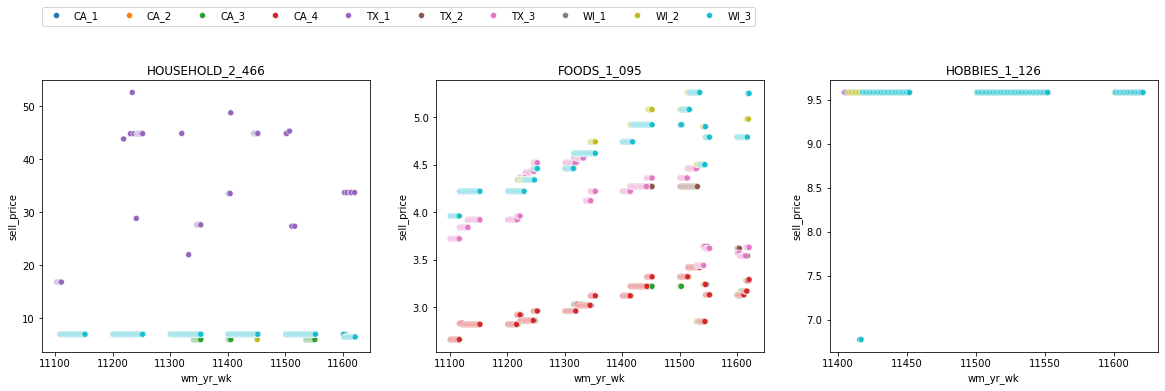

In [104]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))

ax = axs[0]
item_id = "HOUSEHOLD_2_466"
daux = prices[prices["item_id"]==item_id]
sns.scatterplot(x=daux["wm_yr_wk"], y=daux["sell_price"], hue=daux["store_id"], ax=ax)
_ = ax.set_title(item_id)
ax.legend(loc=(0.,1.2), ncol=10)

ax = axs[1]
item_id = "FOODS_1_095"
daux = prices[prices["item_id"]==item_id]
sns.scatterplot(x=daux["wm_yr_wk"], y=daux["sell_price"], hue=daux["store_id"], ax=ax)
_ = ax.set_title(item_id)
ax.legend().set_visible(False)

ax = axs[2]
item_id = "HOBBIES_1_126"
daux = prices[prices["item_id"]==item_id]
sns.scatterplot(x=daux["wm_yr_wk"], y=daux["sell_price"], hue=daux["store_id"], ax=ax)
_ = ax.set_title(item_id)
ax.legend().set_visible(False)


In [105]:

# ax = sns.scatterplot(data=ds, x="wm_yr_wk", y="sell_price", hue="store_id")
# ax.legend(loc=(1.03,0))

### Sale Data

In [106]:
sales = load_sales(PATH_INPUT, load_prices(PATH_INPUT))
print(sales.shape)
sales.head()

(30490, 1947)


item_id    dept_id   cat_id store_id state_id  d_1  d_2  d_3  d_4  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   

   d_5  ...  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  \
0  0.0  ...     4.0     0.0     0.0     0.0     0.0     3.0     3.0     0.0   
1  0.0  ...     1.0     2.0     1.0     1.0     0.0     0.0     0.0     0.0   
2  0.0  ...     0.0     2.0     0.0     0.0     0.0     2.0     3.0     0.0   
3  0.0  ...     1.0     0.0     4.0     0.0     1.0     3.0     0.0     2.0   
4  0.0  ...     0.0     0.0     2.0     1.0     0.0     0.0     2.0     1.0   

   d_1941                             id  
0     1.0  HOBBIES_1_001_CA_1_evaluation  
1     0.0  HOBBIES_1_002_CA_1_evaluation  
2     1.0  HOBBIES_1_003_CA_1_evaluation  
3     6.0  HOBBIES_1_004_CA_1_evaluation  
4     0.0  HOBBIES_1_005_CA_1_evaluation  

[5 rows x 1947 columns]

In [ ]:
# count nulls 
sales.isnull().sum()

In [293]:
id_cols = [c for c in sales.columns if c.upper().endswith("ID")]
sales[id_cols].head()

item_id    dept_id   cat_id store_id state_id  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA   

                              id  
0  HOBBIES_1_001_CA_1_evaluation  
1  HOBBIES_1_002_CA_1_evaluation  
2  HOBBIES_1_003_CA_1_evaluation  
3  HOBBIES_1_004_CA_1_evaluation  
4  HOBBIES_1_005_CA_1_evaluation

#### Compute percentages over year week to see if there is some seasonalty 

In [152]:


def merge_calendar(sales):
    day_cols = [c for c in sales.columns if c not in id_cols]
    df = sales[["state_id", "store_id"]+day_cols].groupby(["state_id", "store_id"], observed=False).sum().stack().reset_index()
    df.columns = ["state_id", "store_id", "day", "sales"]
    df = pd.merge(left=df, right= calendar, left_on="day", right_on="d", how="left")
    return df

# state_sales = f(sales)
state_sales = merge_calendar(load_sales(PATH_INPUT, load_prices(PATH_INPUT)))
print(state_sales.shape)
print(state_sales.dtypes)
state_sales.head()


(58230, 14)
state_id              category
store_id              category
day                     object
sales                  float32
date            datetime64[ns]
wm_yr_wk                uint16
event_name_1          category
event_type_1          category
event_name_2          category
event_type_2          category
snap_CA                  uint8
snap_TX                  uint8
snap_WI                  uint8
d                     category
dtype: object


state_id store_id  day   sales       date  wm_yr_wk event_name_1  \
0       CA     CA_1  d_1  4337.0 2011-01-29     11101          nan   
1       CA     CA_1  d_2  4155.0 2011-01-30     11101          nan   
2       CA     CA_1  d_3  2816.0 2011-01-31     11101          nan   
3       CA     CA_1  d_4  3051.0 2011-02-01     11101          nan   
4       CA     CA_1  d_5  2630.0 2011-02-02     11101          nan   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI    d  
0          nan          nan          nan        0        0        0  d_1  
1          nan          nan          nan        0        0        0  d_2  
2          nan          nan          nan        0        0        0  d_3  
3          nan          nan          nan        1        1        0  d_4  
4          nan          nan          nan        1        0        1  d_5

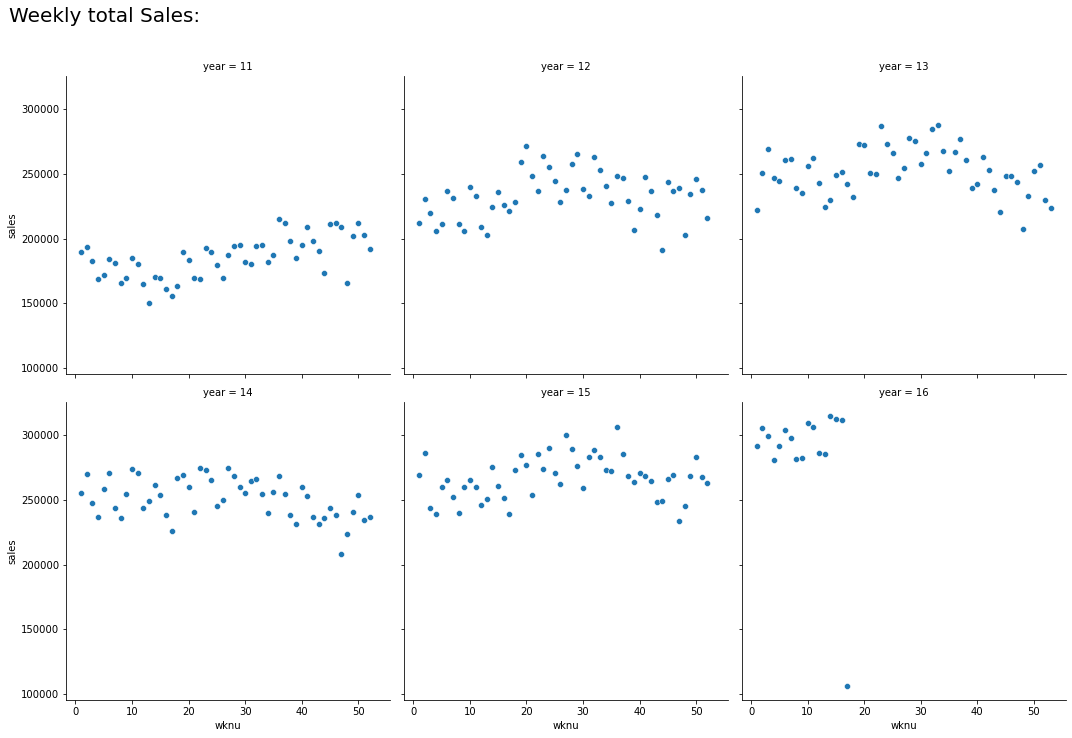

In [212]:
def preprocess_wm_yr_wk(df):
    df["year"] = df["wm_yr_wk"].apply(lambda x: int(str(x)[1:3]))
    df["wknu"] = df["wm_yr_wk"].apply(lambda x: int(str(x)[-2:]))
    df["pack4wk"] = df["wknu"]//4
    return df

s = state_sales.groupby("wm_yr_wk")["sales"].sum().reset_index()
s = preprocess_wm_yr_wk(s)
fg = sns.relplot(x=s["wknu"], y=s["sales"], col=s["year"], col_wrap=3)
_ = fg.fig.suptitle("Weekly total Sales:", x=0.1, y=1.02, fontsize=20)
fg.fig.tight_layout()
fg.fig.savefig("weekly_sales.png", bbox_inches="tight", dpi=100)

In [183]:
# NOTE: Last week in data has a half to the sales weekly average. 
# NOTE: I will group data weekly to predict demand 

wm_yr_wk     sales  year  wknu  pack4wk
268     11608  281241.0    16     8        2
269     11609  282697.0    16     9        2
270     11610  309668.0    16    10        2
271     11611  306203.0    16    11        2
272     11612  286524.0    16    12        3
273     11613  285110.0    16    13        3
274     11614  315125.0    16    14        3
275     11615  312451.0    16    15        3
276     11616  311979.0    16    16        4
277     11617  105856.0    16    17        4

#### What if we group data every 4 weeks ? 

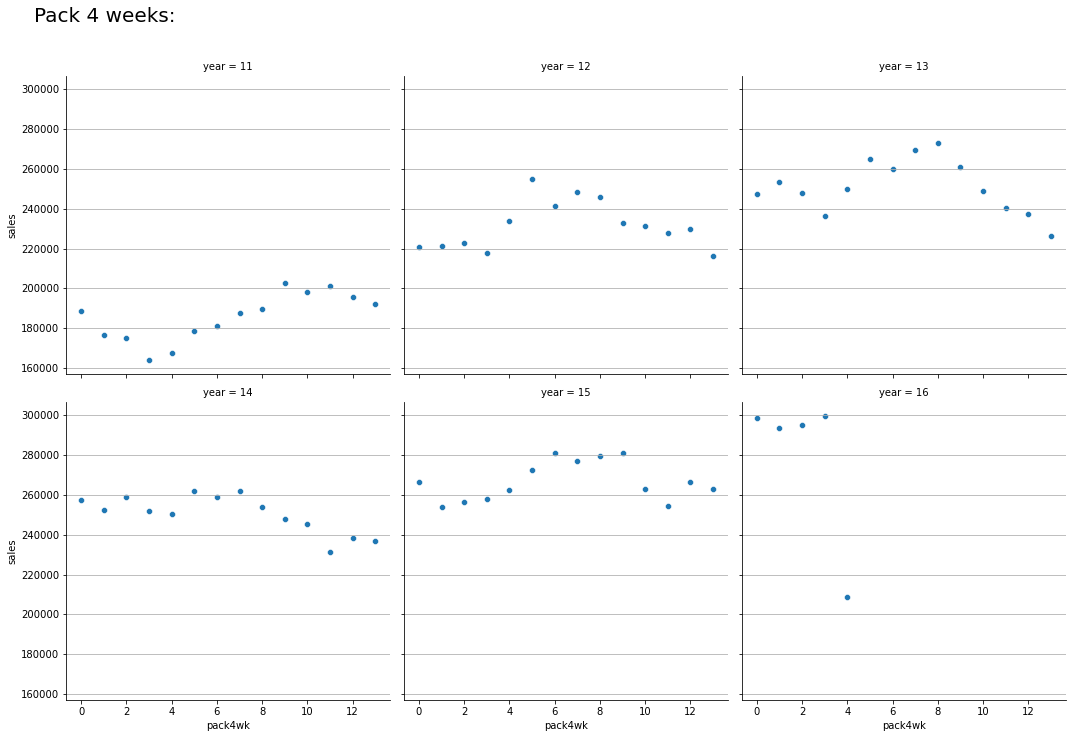

In [213]:
s = state_sales.groupby("wm_yr_wk")["sales"].sum().reset_index()
s["year"] = s["wm_yr_wk"].apply(lambda x: int(str(x)[1:3]))
s["wknu"] = s["wm_yr_wk"].apply(lambda x: int(str(x)[-2:]))
s["pack4wk"] = s["wknu"]//4

fg = sns.relplot(s.groupby(["year", "pack4wk"])["sales"].mean().reset_index(), x="pack4wk", y="sales", col="year", col_wrap=3)
fg.fig.suptitle("Pack 4 weeks:", x=0.1, y=1.02, fontsize=20)
for ax in fg.axes:
    ax.grid(axis="y")
fg.fig.tight_layout()
fg.fig.savefig("pack4wk_sales.png", bbox_inches="tight", dpi=100)

In [221]:
state_sales.head()

state_id store_id  day   sales       date  wm_yr_wk event_name_1  \
0       CA     CA_1  d_1  4337.0 2011-01-29     11101          nan   
1       CA     CA_1  d_2  4155.0 2011-01-30     11101          nan   
2       CA     CA_1  d_3  2816.0 2011-01-31     11101          nan   
3       CA     CA_1  d_4  3051.0 2011-02-01     11101          nan   
4       CA     CA_1  d_5  2630.0 2011-02-02     11101          nan   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI    d  
0          nan          nan          nan        0        0        0  d_1  
1          nan          nan          nan        0        0        0  d_2  
2          nan          nan          nan        0        0        0  d_3  
3          nan          nan          nan        1        1        0  d_4  
4          nan          nan          nan        1        0        1  d_5

In [ ]:
# pack of 4 weeks, "pseudomonth" still contains part of the sesonality
# - Demand starts low at the begining of the year 
# - Demand ends the year reducing sales on average. theincreases,  and towards end of year

In [172]:
s.describe()

wm_yr_wk          sales        year       wknu
count    278.000000     278.000000  278.000000  278.00000
mean   11343.870504  240745.234375   13.183453   25.52518
std      153.567673   35874.113281    1.547846   15.27336
min    11101.000000  105856.000000   11.000000    1.00000
25%    11218.250000  221303.500000   12.000000   12.00000
50%    11335.500000  246343.500000   13.000000   25.00000
75%    11451.750000  265988.250000   14.000000   39.00000
max    11617.000000  315125.000000   16.000000   53.00000

#### Sales per store per week 

In [223]:
state_sales.columns

Index(['state_id', 'store_id', 'day', 'sales', 'date', 'wm_yr_wk',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'd', 'year', 'wknu', 'pack4wk'],
      dtype='object')

In [233]:
state_sales["wm_yr_wk"].unique()

array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
       11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
       11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
       11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
       11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11201, 11202,
       11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211,
       11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220,
       11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229,
       11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238,
       11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247,
       11248, 11249, 11250, 11251, 11252, 11301, 11302, 11303, 11304,
       11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313,
       11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322,
       11323, 11324,

In [ ]:
state_sales["year"] = state_sales["wm_yr_wk"].apply(lambda x: int(str(x)[1:3]))
state_sales["wknu"] = state_sales["wm_yr_wk"].apply(lambda x: int(str(x)[-2:]))
state_sales["pack4wk"] = state_sales["wknu"]//4

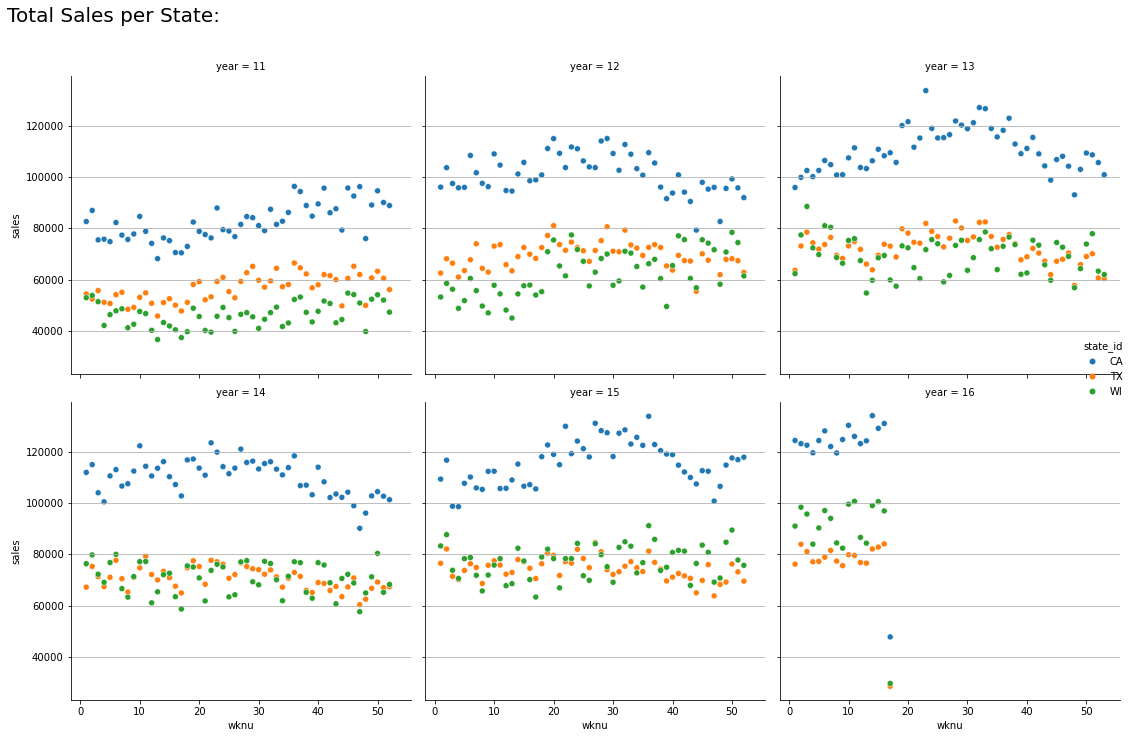

In [ ]:
s = state_sales.groupby(["state_id", "year", "wknu"], observed=True)["sales"].sum().reset_index()
fg = sns.relplot(s, x="wknu", y="sales", col="year", hue="state_id", col_wrap=3)
fg.fig.suptitle("Total Sales per State:", x=0.1, y=1.02, fontsize=20)
for ax in fg.axes:
    ax.grid(axis="y")
fg.fig.tight_layout()
fg.fig.savefig("sales_per_year_state.png", bbox_inches="tight", dpi=100)

In [235]:
s[s["wknu"]==52]

state_id  year  wknu     sales
51        CA    11    52   88877.0
104       CA    12    52   91967.0
157       CA    13    52  105652.0
210       CA    14    52  101273.0
263       CA    15    52  117869.0
316       CA    16    52       0.0
369       TX    11    52   56092.0
422       TX    12    52   62786.0
475       TX    13    52   60611.0
528       TX    14    52   67307.0
581       TX    15    52   69507.0
634       TX    16    52       0.0
687       WI    11    52   47291.0
740       WI    12    52   61411.0
793       WI    13    52   63286.0
846       WI    14    52   68224.0
899       WI    15    52   75672.0
952       WI    16    52       0.0

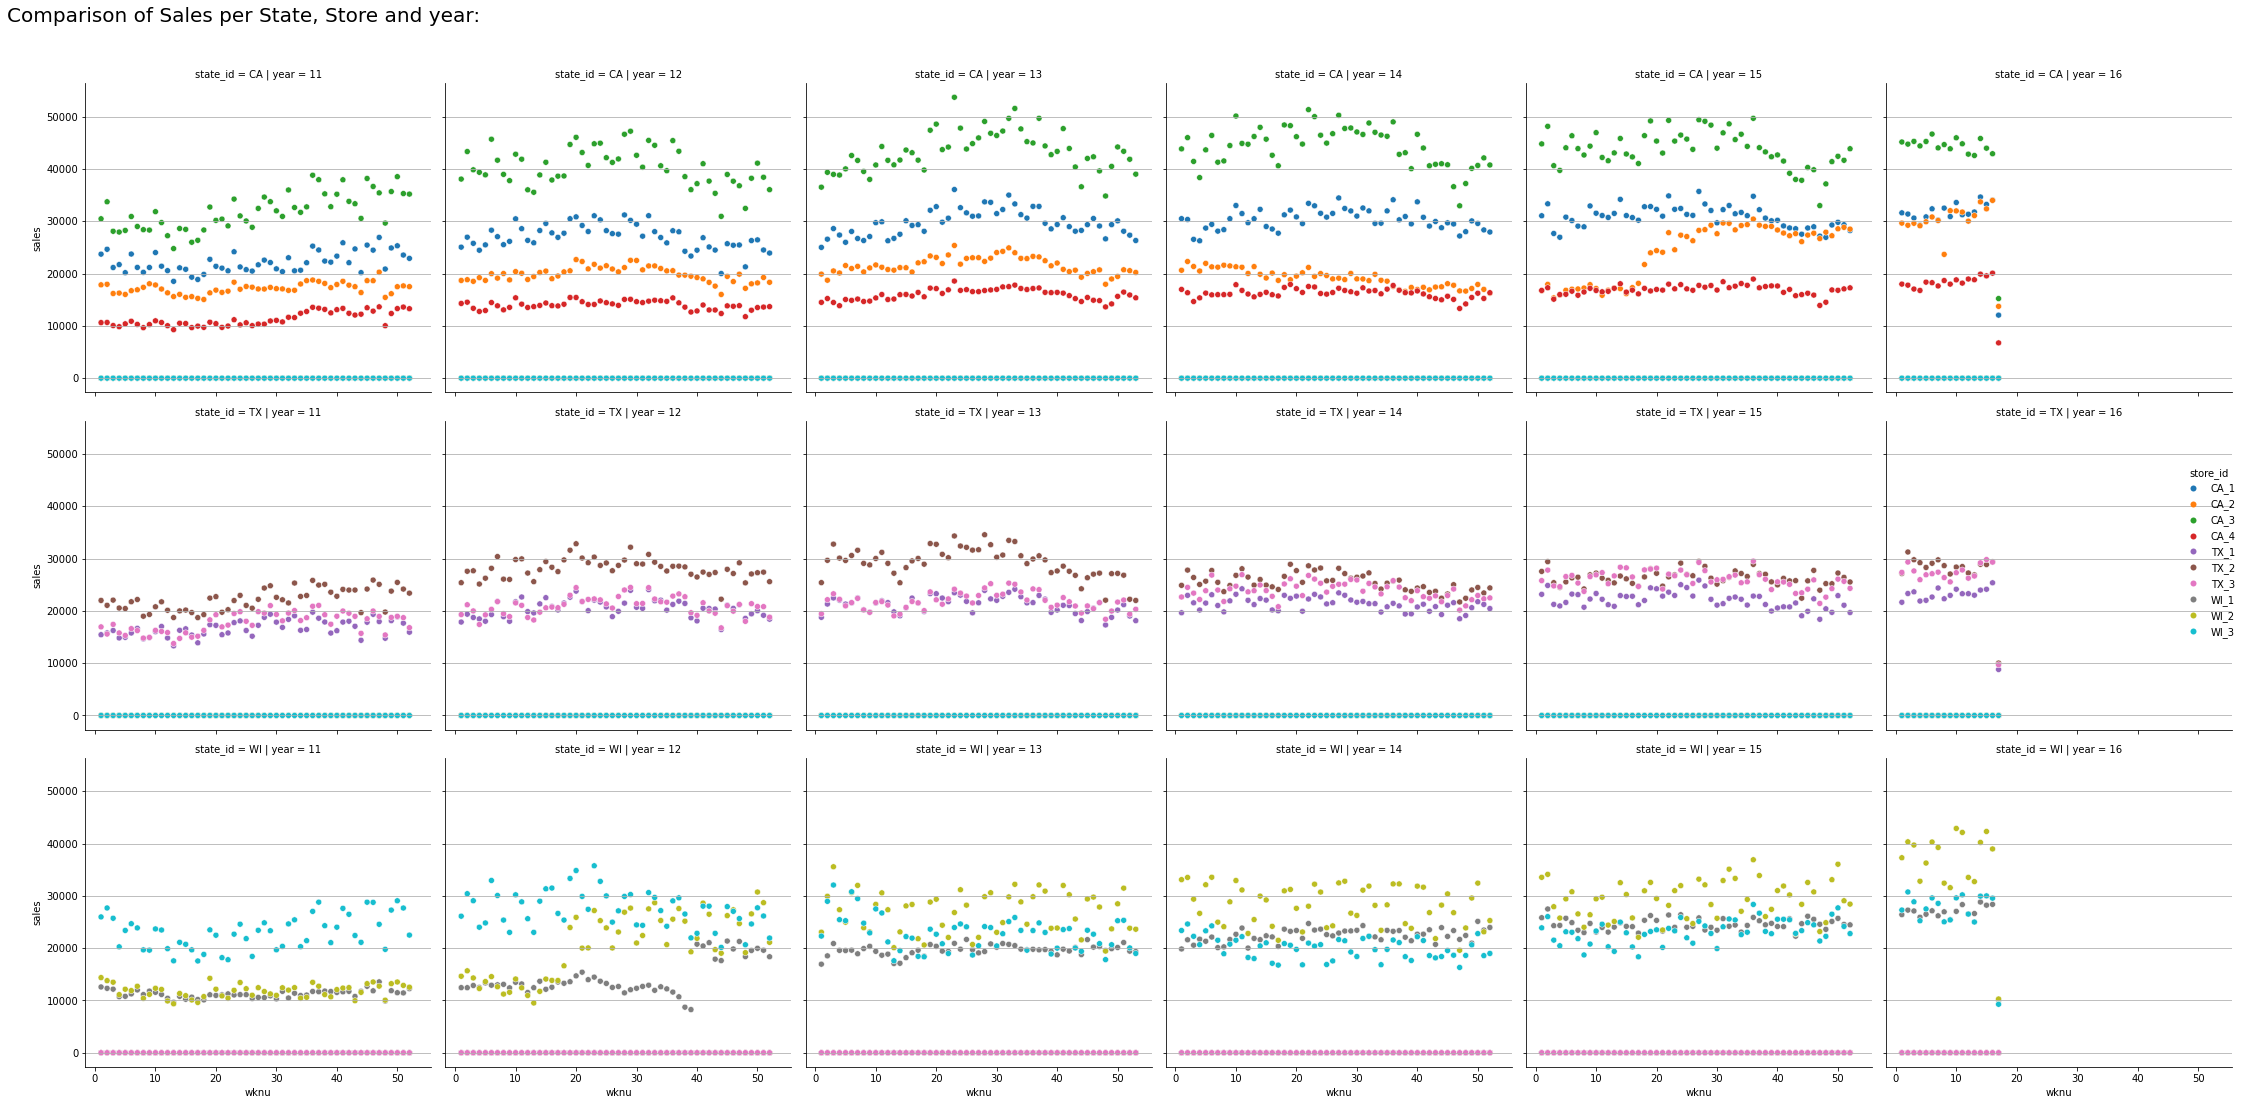

In [241]:
s = state_sales.groupby(["state_id", "store_id", "year", "wknu"], observed=True)["sales"].sum().reset_index()
fg = sns.relplot(s, x="wknu", y="sales", col="year", hue="store_id", row="state_id")
for ax in fg.axes.flatten():
    ax.grid(axis="y")
_ = fg.fig.suptitle("Comparison of Sales per State, Store and year:", x=0.1, y=1.02, fontsize=20)

fg.fig.tight_layout()
fg.fig.savefig("sales_comparison_state_store_year.png", bbox_inches="tight", dpi=100)

count     1941.000000
mean     34480.769531
std       7425.905762
min         11.000000
25%      29713.000000
50%      33830.000000
75%      39008.000000
max      59921.000000
Name: sales, dtype: float64

<AxesSubplot:xlabel='date', ylabel='sales'>

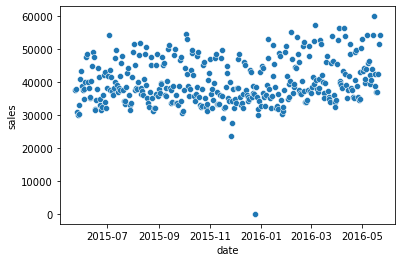

In [176]:
r = state_sales.groupby("date")["sales"].sum().sort_index()
display(r.describe())
sns.scatterplot(r.iloc[-365:])#, x="date", y="sales")

In [ ]:
# NOTE: Demand/sales seems to have some weekly seasonality. 

In [215]:
s = sales.groupby(["cat_id"], observed=False)[day_cols].sum().T
daux = pd.merge(calendar[['date', 'd']], s, left_on="d", right_index=True).drop(columns="d")
daux

date  HOBBIES  HOUSEHOLD    FOODS
0    2011-01-29   3764.0     5689.0  23178.0
1    2011-01-30   3357.0     5634.0  22758.0
2    2011-01-31   2682.0     3927.0  17174.0
3    2011-02-01   2669.0     3865.0  18878.0
4    2011-02-02   1814.0     2729.0  14603.0
...         ...      ...        ...      ...
1936 2016-05-18   3740.0     8566.0  24790.0
1937 2016-05-19   3475.0     8751.0  24737.0
1938 2016-05-20   4143.0    10273.0  28136.0
1939 2016-05-21   5333.0    12586.0  33599.0
1940 2016-05-22   5280.0    13091.0  35967.0

[1941 rows x 4 columns]

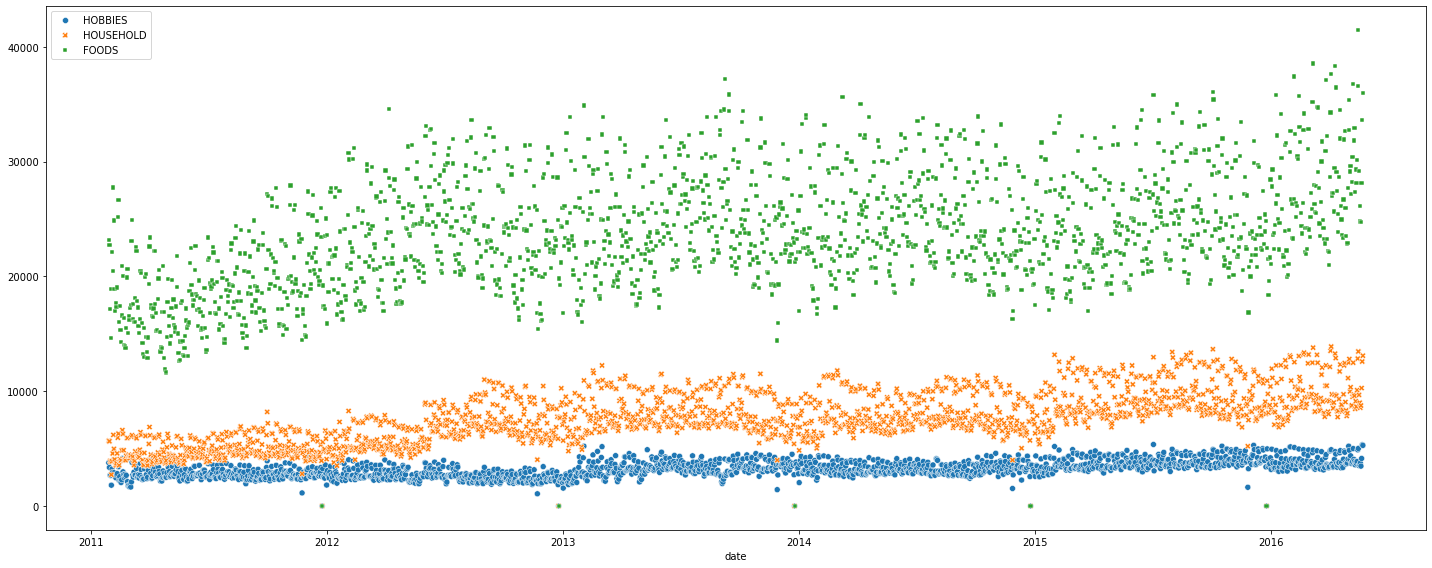

In [216]:
fig, ax = plt.subplots(figsize=(20,8)) 
_ = sns.scatterplot(data=daux.set_index("date"), ax=ax)
fig.tight_layout()
fig.savefig("sales_per_categories.png", bbox_inches="tight", dpi=100)

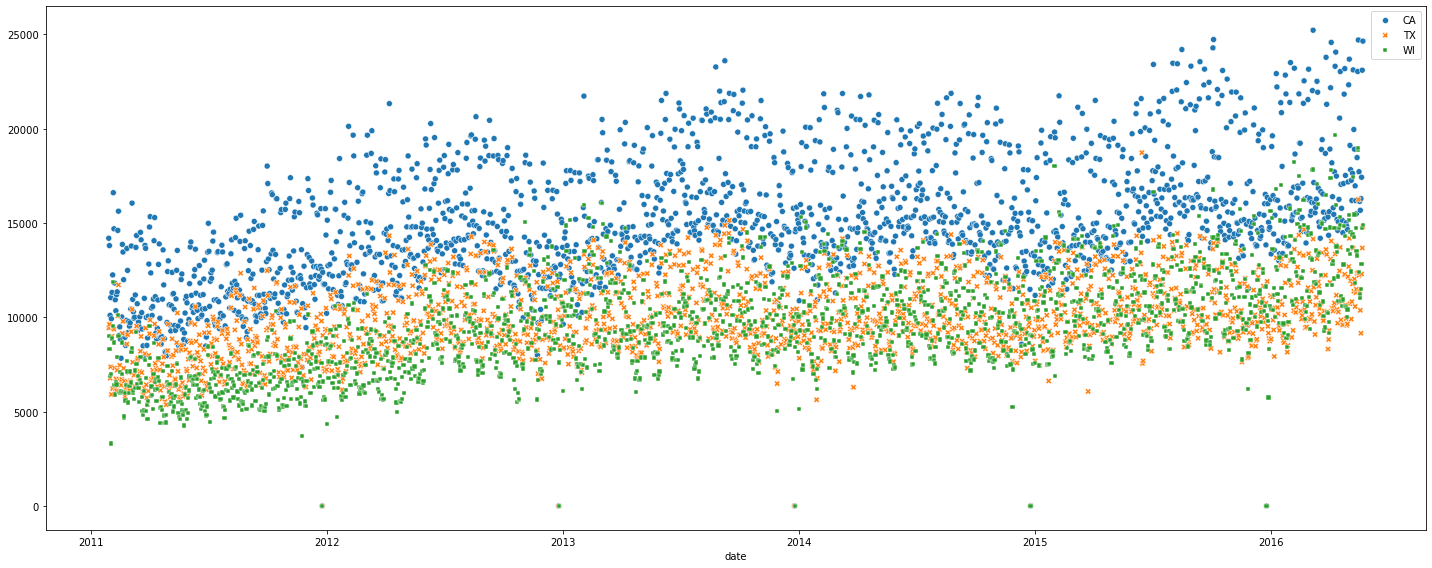

In [217]:
s = sales.groupby(["state_id"], observed=False)[day_cols].sum().T
daux = pd.merge(calendar[['date', 'd']], s, left_on="d", right_index=True).drop(columns="d")

fig, ax = plt.subplots(figsize=(20,8))
_ = sns.scatterplot(data=daux.set_index("date"), ax=ax)
fig.tight_layout()
fig.savefig("sales_per_state.png", bbox_inches="tight", dpi=100)

In [220]:
sales.head()

item_id    dept_id   cat_id store_id state_id  d_1  d_2  d_3  d_4  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA  0.0  0.0  0.0  0.0   

   d_5  ...  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  \
0  0.0  ...     4.0     0.0     0.0     0.0     0.0     3.0     3.0     0.0   
1  0.0  ...     1.0     2.0     1.0     1.0     0.0     0.0     0.0     0.0   
2  0.0  ...     0.0     2.0     0.0     0.0     0.0     2.0     3.0     0.0   
3  0.0  ...     1.0     0.0     4.0     0.0     1.0     3.0     0.0     2.0   
4  0.0  ...     0.0     0.0     2.0     1.0     0.0     0.0     2.0     1.0   

   d_1941                             id  
0     1.0  HOBBIES_1_001_CA_1_evaluation  
1     0.0  HOBBIES_1_002_CA_1_evaluation  
2     1.0  HOBBIES_1_003_CA_1_evaluation  
3     6.0  HOBBIES_1_004_CA_1_evaluation  
4     0.0  HOBBIES_1_005_CA_1_evaluation  

[5 rows x 1947 columns]

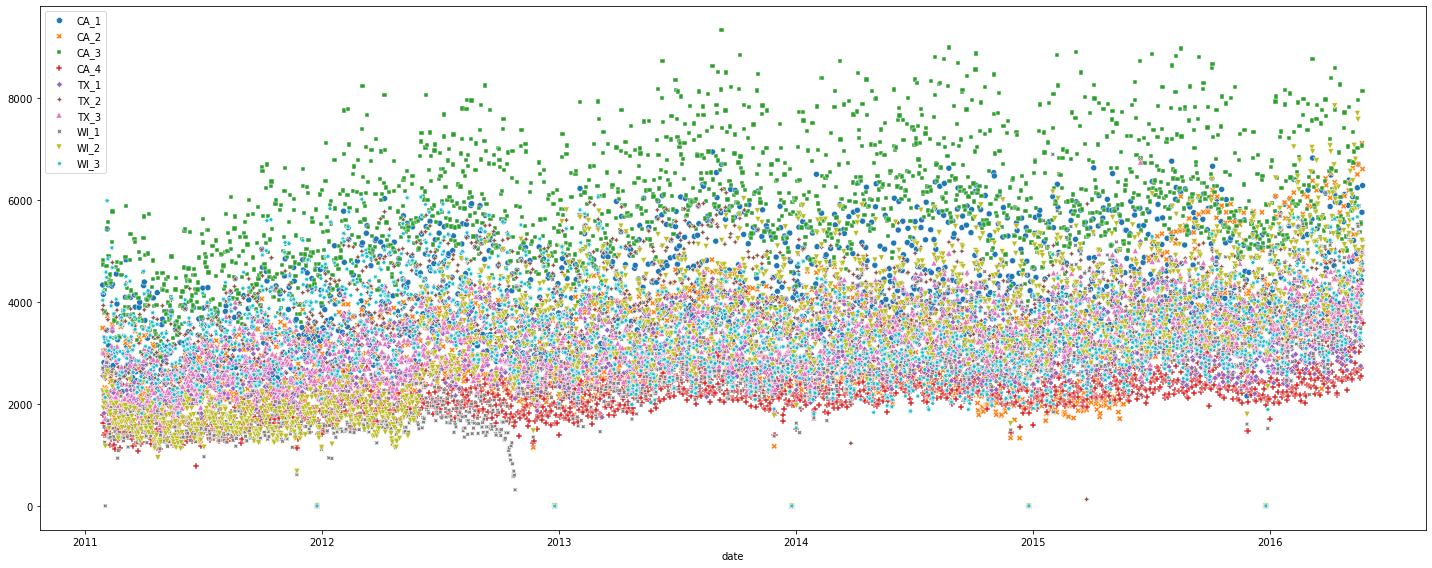

In [218]:
s = sales.groupby(["store_id"], observed=False)[day_cols].sum().T
daux = pd.merge(calendar[['date', 'd']], s, left_on="d", right_index=True).drop(columns="d")

fig, ax = plt.subplots(figsize=(20,8))
_ = sns.scatterplot(data=daux.set_index("date"), ax=ax)
fig.tight_layout()
fig.savefig("sales_per_store.png", bbox_inches="tight", dpi=100)

<AxesSubplot:ylabel='cat_id-state_id'>

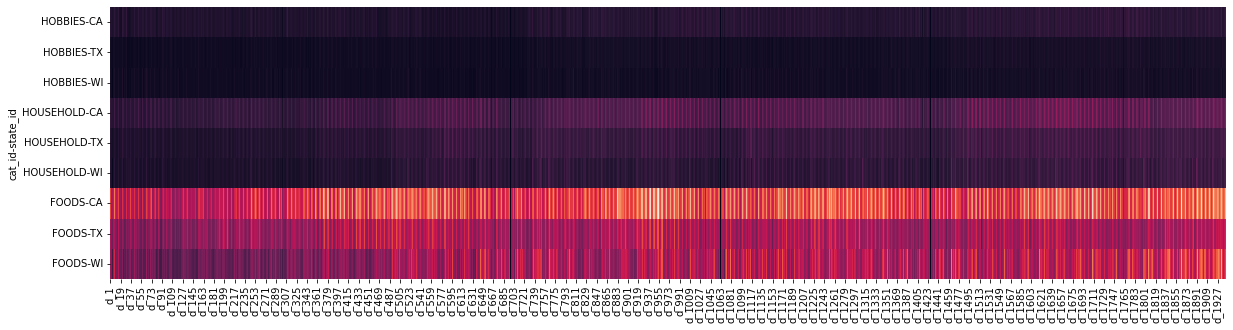

In [77]:
# s = sales.groupby(["cat_id", "state_id"], observed=False)[day_cols].sum()
# # daux = pd.merge(calendar[['date', 'd']], s, left_on="d", right_index=True).drop(columns="d")
# # daux
# fig, ax = plt.subplots(figsize=(20,5))
# sns.heatmap(s, ax=ax, cbar=False)

<AxesSubplot:xlabel='date'>

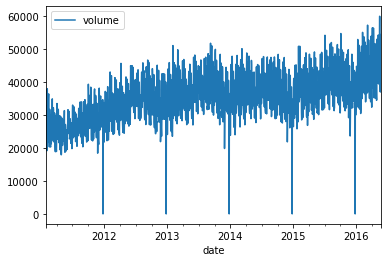

In [107]:
# Total volume of items sold:
day_cols = [c for c in sales.columns if c not in id_cols]
s = sales[day_cols].sum()
s.name = "volume"
daux = pd.merge(calendar[['date', 'd']], s, left_on="d", right_index=True)
daux.plot("date", 'volume')

date  wm_yr_wk    event_name_1 event_type_1    event_name_2  \
85   2011-04-24     11113  OrthodoxEaster    Religious          Easter   
827  2013-05-05     11315  OrthodoxEaster    Religious   Cinco De Mayo   
1177 2014-04-20     11412          Easter     Cultural  OrthodoxEaster   
1233 2014-06-15     11420    NBAFinalsEnd     Sporting    Father's day   
1968 2016-06-19     11621    NBAFinalsEnd     Sporting    Father's day   

     event_type_2  snap_CA  snap_TX  snap_WI       d  
85       Cultural        0        0        0    d_86  
827      Cultural        1        1        1   d_828  
1177    Religious        0        0        0  d_1178  
1233     Cultural        0        1        1  d_1234  
1968     Cultural        0        0        0  d_1969

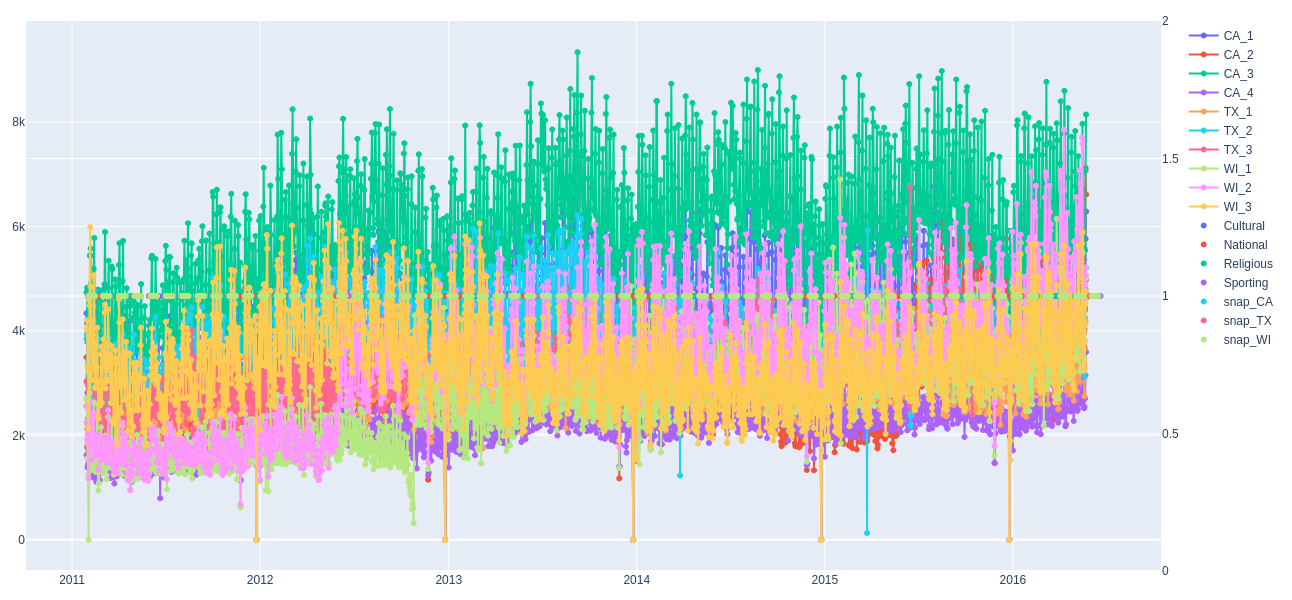

In [245]:
fig = go.Figure()
state = "CA"


traces = []
calendar_traces = []
common_calendar_traces_params = dict(mode='markers', yaxis='y2',hoverinfo='text')
for et1, dp in calendar[calendar["event_type_1"]!="nan"].groupby("event_type_1", observed=False):
    calendar_traces.append(go.Scatter(
        x=dp['date'].values, 
        y=dp['event_type_1'].map(lambda x: 1 if x==et1 else 0), 
        name=et1, 
        text=dp[['event_name_1', 'date']].apply(lambda x: f"{x.iloc[0]}, {x.iloc[1]}", axis=1),
        **common_calendar_traces_params
    ))

for state in ["CA", "TX", "WI"]:
    dp = calendar[calendar[f"snap_{state}"]==1]
    calendar_traces.append(go.Scatter(
        x=dp['date'].values, 
        y=dp[f"snap_{state}"], 
        name=f"snap_{state}", 
        text=f"snap_{state}",
        **common_calendar_traces_params
    ))

traces = []
stores_map = {
    "CA": ["CA_1", "CA_2", "CA_3", "CA_4"], 
    "TX": ["TX_1", "TX_2", "TX_3"], 
    "WI": ["WI_1", "WI_2", "WI_3"]
}

for state in ["CA", "TX", "WI"]:    
    cond = (state_sales["state_id"] == state) 
    dp = state_sales[cond].copy()
    for store_id in stores_map[state]:
        cond2 = dp["store_id"]==store_id
        traces.append(
            go.Scatter(
                x=dp[cond2]['date'].values,
                y=dp[cond2]['sales'],
                mode='lines+markers',
                name=store_id,
                yaxis='y',
            )
        )

fig.add_traces(traces+calendar_traces)

fig.update_layout(
    title="",
    yaxis2=dict(
        # title='Secondary Y-axis',
        overlaying='y',  # To overlay on the same plot
        side='right'  # Place on the right side
    ),
    hovermode='x unified',
    width=1400,
    height=600,
    margin={"t": 10, "b": 10, "l": 10, "r": 10}
)

fig.write_html(file="full_data_exploration.html")
fig.show()

In [ ]:
# NOTE: Zero demand on Christmas!
# NOTE: Include Cultural, National Religious and Sporting (event_type_1 events)
# NOTE: IT is not clear that SNAP variables have some impact. 

### Prices

In [250]:
prices = load_prices(PATH_INPUT)
print(prices.shape)
prices.head()

(6841121, 4)


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [253]:
prices = preprocess_wm_yr_wk(prices)
prices["cat_id"] = prices["item_id"].apply(lambda x: x.split("_")[0])
prices.head()

store_id        item_id  wm_yr_wk  sell_price  year  wknu  pack4wk   cat_id
0     CA_1  HOBBIES_1_001     11325        9.58    13    25        6  HOBBIES
1     CA_1  HOBBIES_1_001     11326        9.58    13    26        6  HOBBIES
2     CA_1  HOBBIES_1_001     11327        8.26    13    27        6  HOBBIES
3     CA_1  HOBBIES_1_001     11328        8.26    13    28        7  HOBBIES
4     CA_1  HOBBIES_1_001     11329        8.26    13    29        7  HOBBIES

In [295]:
print([c for c in prices["item_id"].unique() if "HOBBIES" in c.upper()][:5])
print()
print([c for c in prices["item_id"].unique() if "HOUSE" in c.upper()][:5])
print()
print([c for c in prices["item_id"].unique() if "FOOD" in c.upper()][:5])

['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', 'HOBBIES_1_004', 'HOBBIES_1_005']

['HOUSEHOLD_1_001', 'HOUSEHOLD_1_002', 'HOUSEHOLD_1_003', 'HOUSEHOLD_1_004', 'HOUSEHOLD_1_005']

['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', 'FOODS_1_004', 'FOODS_1_005']


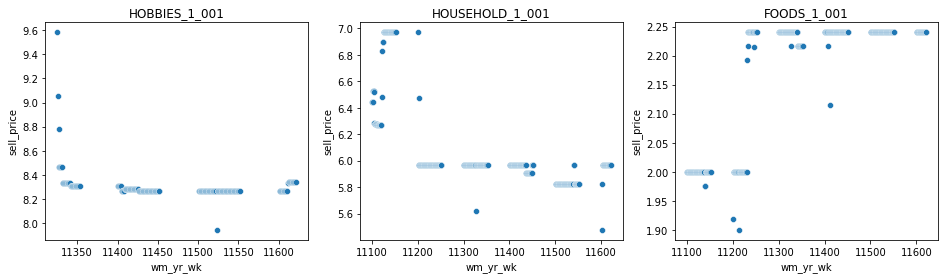

In [279]:
s = prices.groupby(["item_id", "wm_yr_wk"], observed=True)["sell_price"].mean().reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(16,4))

for i, iid in enumerate(["HOBBIES_1_001", "HOUSEHOLD_1_001", "FOODS_1_001"]):
    cond = s["item_id"] == iid
    ax = sns.scatterplot(s[cond], x="wm_yr_wk", y="sell_price", ax=axs[i])
    _ = ax.set_title(iid)

### Price vs time all products

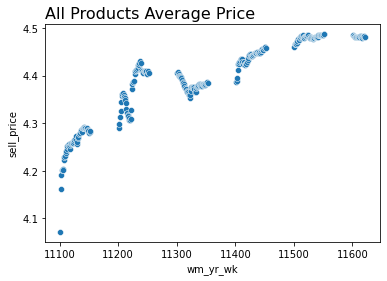

In [262]:
s = prices.groupby("wm_yr_wk")["sell_price"].mean()
ax = sns.scatterplot(s)
_ = ax.set_title("All Products Average Price", loc="left", fontsize=16)

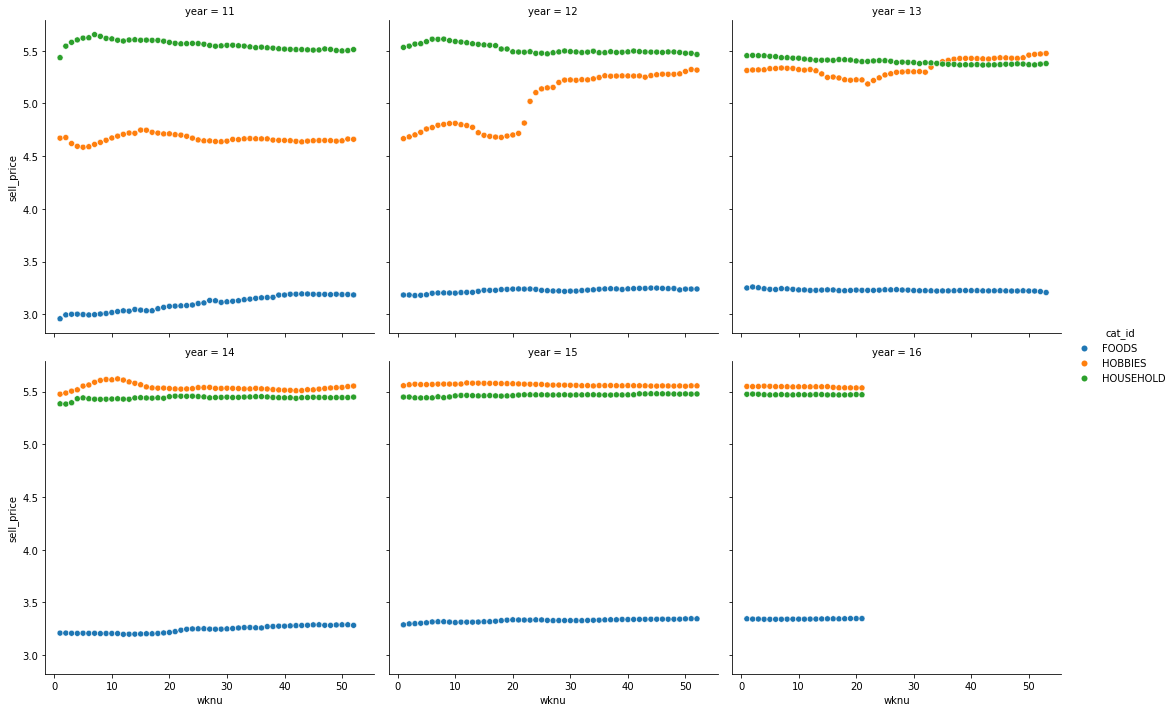

In [258]:
s = prices.groupby(["cat_id", "year", "wknu"])["sell_price"].mean().reset_index()
sns.relplot(s, x="wknu", y="sell_price", col="year",  hue="cat_id", col_wrap=3)

In [ ]:
# NOTE: Hobbies seems to have a weird behaviour on somme years (e.g: 2012). 
# NOTE: Price variation seems to be smooth on last 3 years of data. 

In [305]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price  year  wknu  pack4wk   cat_id
0     CA_1  HOBBIES_1_001     11325        9.58    13    25        6  HOBBIES
1     CA_1  HOBBIES_1_001     11326        9.58    13    26        6  HOBBIES
2     CA_1  HOBBIES_1_001     11327        8.26    13    27        6  HOBBIES
3     CA_1  HOBBIES_1_001     11328        8.26    13    28        7  HOBBIES
4     CA_1  HOBBIES_1_001     11329        8.26    13    29        7  HOBBIES

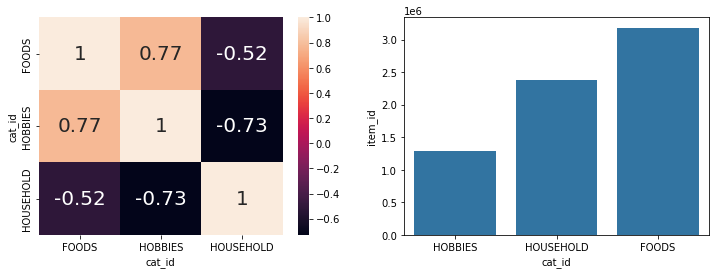

In [316]:
corr = prices.pivot_table(index="wm_yr_wk", columns="cat_id", values="sell_price", aggfunc="mean").corr()

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
ax = sns.heatmap(corr, annot=True, annot_kws={"fontsize": 20}, ax=axs[0])
ax = sns.barplot(prices.groupby("cat_id", observed=True)["item_id"].count().sort_values(), ax=axs[1])

### Counts per item

In [285]:
prices.groupby("cat_id")["item_id"].nunique()

cat_id
FOODS        1437
HOBBIES       565
HOUSEHOLD    1047
Name: item_id, dtype: int64

# PLAN 

1. To forcast 28days i am thinking to create a weekly target demand and predict 4 times (to  get the 28days of demand forcast). or to 28 days demand as single dot forecast.
2. Features some aggregate data weekly
3. Add calendar events that seems to have to predict power (e.g: Christmas may imply 0 demand of products)
4. Last 3 years of data seems reasonable based on weird behaviour of 2012
5. 